## NOTE
* There is a settling time for the filter that makes the initial data look funky
* Frequency difference will show up as zero if the reference and input waves are the same frequency (which is true by default with the method below)
* I think the magnitude result is the mixed wave's amplitude, but for some reason I had to scale it 2x to get the actual result

setting up wave functions...


Text(0.5, 1.0, 'Frequency difference between input wave and reference wave')

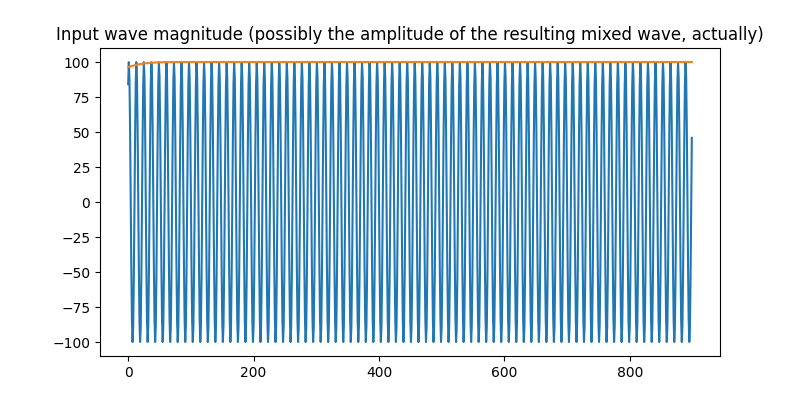

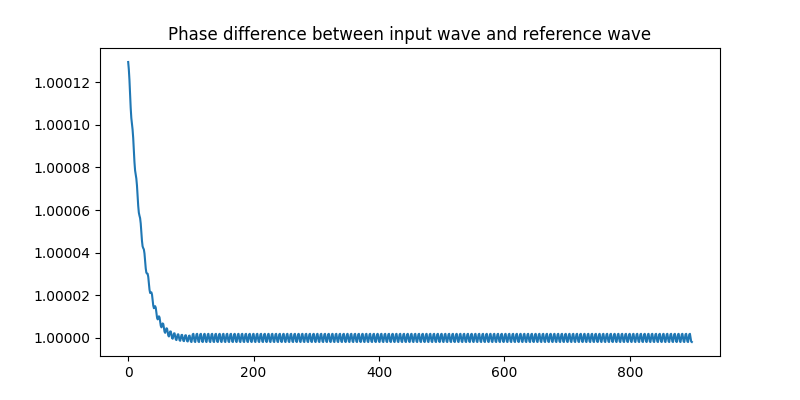

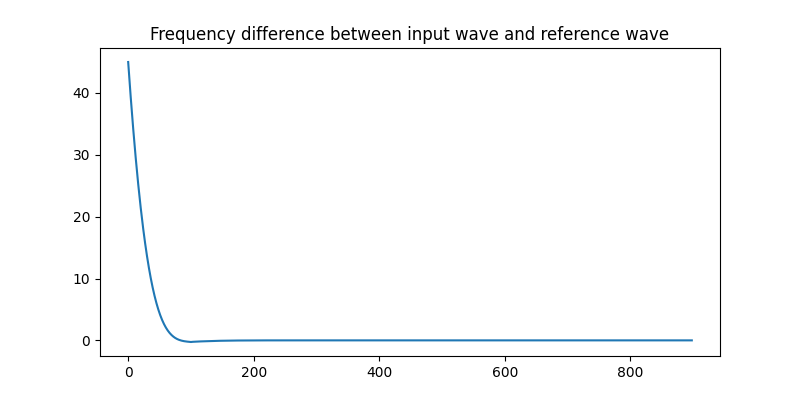

In [5]:
!python "wavefunctions.py"
from wavefunctions import GenerateSinewavePoints, GenerateSinewavePeriods
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, FloatSlider, IntSlider, Layout
import scipy.signal as signal

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#disable the axis offset that's normaly auto applied when numbers get too small or large
plt.rcParams['axes.formatter.useoffset'] = False

def DigitalLockInAmplifier(sampleRate, frequency, inputArray, phaseOffset=0, magOffset=0):
    firFilter = signal.firwin(201, cutoff = 100, window = "hamming", pass_zero = "lowpass", fs=sampleRate)
    
    #either way here works fine
    #x = np.arange(0, inputArray.size)
    #gain = 1.0
    #referenceWaveInPhase = gain * np.sin(math.pi*2*frequency/sampleRate * x)
    #referenceWaveQuadrature = gain * np.cos(math.pi*2*frequency/sampleRate * x)
    
    referenceWaveInPhase = GenerateSinewavePoints(sampleRate, frequency, 1, 0, inputArray.size)
    referenceWaveQuadrature = GenerateSinewavePoints(sampleRate, frequency, 1, math.pi/2, inputArray.size)
    
    inPhase = referenceWaveInPhase * inputArray
    quadrature = referenceWaveQuadrature * inputArray
    #analytic_signal = inPhase + 1j * quadrature
    
    inPhaseFilt = signal.lfilter(firFilter, 1, inPhase)
    quadratureFilt = signal.lfilter(firFilter, 1, quadrature)
    analyticSignalFilt = inPhaseFilt + 1j * quadratureFilt
    
    
    #phaseRad = np.arctan2(quadrature, inPhase)
    phaseRad = np.unwrap(np.angle(analyticSignalFilt))#this gives a continuously increasing phase angle in radians (somehow), that doesn't wrap when the period ends
    phaseRad = signal.lfilter(firFilter, 1, phaseRad)
    #vfunc = np.vectorize(NormalizeAngleRad)
    #phaseRad = vfunc(phaseRad)
    #phaseDeg = phaseRad * 180.0 / math.pi
    
    #TODO: why is the 2 * needed here?  It's the only way to get the right answer, but I have no idea why.  
    #mag = 2 * np.sqrt(inPhaseFilt * inPhaseFilt + quadratureFilt * quadratureFilt) - magOffset;
    mag = 2 * np.abs(analyticSignalFilt) - magOffset
    mag = signal.lfilter(firFilter, 1, mag)#works much better than filtering i and q separately before this (??? not so in generated wave testing)
    
    freq = (np.diff(phaseRad) / (2.0*np.pi) * sampleRate)
    freq = signal.lfilter(firFilter, 1, freq)#freq seems to need extra filtering
    
    return (phaseRad, mag, freq)

sampleRate = 192000
wave1 = GenerateSinewavePeriods(sampleRate, 16000, 100.0, 1.0, 100)

dliaResult = DigitalLockInAmplifier(sampleRate, 16000, wave1)
phase = dliaResult[0]
mag = dliaResult[1]
freq = dliaResult[2]

plotStartIndex = 300

fig = plt.figure()
plt.plot(wave1[plotStartIndex:])
plt.plot(mag[plotStartIndex:])
plt.title("Input wave magnitude (possibly the amplitude of the resulting mixed wave, actually)")

fig = plt.figure()
plt.plot(phase[plotStartIndex:])
plt.title("Phase difference between input wave and reference wave")

fig = plt.figure()
plt.plot(freq[plotStartIndex:])
plt.title("Frequency difference between input wave and reference wave")